In [ ]:
import json, pathlib

inventory = json.loads(pathlib.Path("/scr/BEHAVIOR-1K/asset_pipeline/artifacts/pipeline/object_inventory.json").read_text())
providers = {k.split("-")[1]: v for k, v in inventory["providers"].items()}

In [19]:
import sys
sys.path.append("/scr/BEHAVIOR-1K/asset_pipeline")
from b1k_pipeline.utils import parse_name, load_mesh

In [3]:
EXCLUDE_CATEGORIES = {"walls", "floors", "ceilings", "driveway", "lawn", "background", "roof"}

In [4]:
import csv

# Load the rename file
RENAMES = {}
with open("/scr/BEHAVIOR-1K/asset_pipeline/metadata/object_renames.csv") as f:
    for row in csv.DictReader(f):
        key = (row["ID (auto)"])
        RENAMES[key] = row["New Category"]

# Load the deletion file
DELETION_QUEUE = set()
with open("/scr/BEHAVIOR-1K/asset_pipeline/metadata/deletion_queue.csv", "r") as f:
    for row in csv.DictReader(f):
        DELETION_QUEUE.add(row["Object"].strip().split("-")[1])


def maybe_rename_category(cat, model):
    if model in RENAMES:
        return RENAMES[model]
    return cat


In [5]:
# Process the collision mesh directory
meshdir = pathlib.Path("/scr/cmesh_dataset")

# For every directory in there that is named after a parseable object, rename it
for item in meshdir.glob("*"):
    if item.is_dir():
        name = item.name
        if name.count("-") == 2:
            continue

        parsed_name = parse_name(name)
        if not parsed_name:
            print("Bad name", name)
            continue

        link_name = parsed_name.group("link_name") if parsed_name.group("link_name") else "base_link"
        obj_name = parsed_name.group("category") + "-" + parsed_name.group("model_id") + "-" + link_name
        new_path = meshdir / obj_name
        if new_path.exists():
            print("Collision", new_path, item)
            continue
        item.rename(new_path)

In [6]:
import shutil

# Remove objects that are substances. Those collision meshes will not make sense
from bddl.object_taxonomy import ObjectTaxonomy
ot = ObjectTaxonomy()

for item in meshdir.glob("*"):
    if item.is_dir():
        name = item.stem
        category, mdl, link = name.split("-")
        assert len(mdl) == 6, mdl

        if mdl in DELETION_QUEUE:
            print("Deleting deletion queue item", item)
            shutil.rmtree(item)
            continue

        renamed_category = maybe_rename_category(category, mdl)
        is_substance = ot.get_synset_from_substance(renamed_category) is not None
        is_object = ot.get_synset_from_category(renamed_category) is not None
        assert is_substance or is_object, (renamed_category, item)
        if is_substance:
            print("Deleting substance", item)
            shutil.rmtree(item)
            continue

        if renamed_category in EXCLUDE_CATEGORIES:
            print("Deleting excluded category", item)
            shutil.rmtree(item)
            continue

        # Apply the rename if necessary
        if category != renamed_category:
            new_path = meshdir / (renamed_category + "-" + mdl + "-" + link)
            if new_path.exists():
                print("Collision", new_path, item)
                continue
            item.rename(new_path)

In [7]:
# Now load the JSONs
selections = {}
for fn in pathlib.Path("/scr/BEHAVIOR-1K/asset_pipeline/cad").glob("*/*/artifacts/collision_selection.json"):
    target = "/".join(fn.parts[-4:-2])
    for name, selection in json.loads(fn.read_text()).items():
        parsed_name = parse_name(name)
        if not parsed_name:
            print("Bad name", name)
            continue

        # model_id = parsed_name.group("model_id")
        # if model_id in DELETION_QUEUE or model_id not in providers:
        #     print("Deleting deletion queue item", name)
        #     continue

        if providers[parsed_name.group("model_id")] != target:
            print("Mismatch", name, target)
            continue

        # renamed_category = maybe_rename_category(parsed_name.group("category"), model_id)
        # is_substance = ot.get_synset_from_substance(renamed_category) is not None
        # if is_substance:
        #     print("Deleting substance", name)
        #     continue

        # if renamed_category in EXCLUDE_CATEGORIES:
        #     print("Deleting excluded category", name)
        #     continue

        link_name = parsed_name.group("link_name") if parsed_name.group("link_name") else "base_link"
        selection_name = parsed_name.group("model_id") + "-" + link_name

        selections[selection_name] = selection

Deleting deletion queue item pot_plant-oqgjvf-0
Deleting deletion queue item walls-atwggi-0
Deleting deletion queue item walls-ektfoc-0
Deleting deletion queue item walls-frxclj-0
Deleting deletion queue item walls-hamprb-0-Tglass
Deleting deletion queue item walls-hjysyd-0-Tglass
Deleting deletion queue item walls-hnkbeg-0-Tglass
Deleting deletion queue item walls-jftedu-0-Tglass
Deleting deletion queue item walls-kitdqs-0-Tglass
Deleting deletion queue item walls-oelinm-0
Deleting deletion queue item walls-omtice-0-Tglass
Deleting deletion queue item walls-qnuxpd-0
Deleting deletion queue item walls-qofznc-0
Deleting deletion queue item walls-rcfqrs-0-Tglass
Deleting deletion queue item walls-rgvfvf-0
Deleting deletion queue item walls-vjmnpj-0-Tglass
Deleting deletion queue item walls-yrgbma-0-Tglass
Deleting deletion queue item L-cup-lfxtqa-0
Deleting deletion queue item L-cup-vlikrk-0
Deleting deletion queue item L-cup-wfavfd-0
Deleting deletion queue item L-mouse-ptwame-0
Deletin

In [8]:
from fs.zipfs import ZipFS
import fs.path

for fn in pathlib.Path("/scr/BEHAVIOR-1K/asset_pipeline/cad").glob("*/*/artifacts/meshes.zip"):
    target = "/".join(fn.parts[-4:-2])
    with ZipFS(fn) as zip_fs:
        for name in zip_fs.glob("*/*Mcollision*.obj"):
            name = fs.path.splitext(fs.path.basename(name.path))[0].rsplit("-", 1)[0]
            parsed_name = parse_name(name)
            if not parsed_name:
                print("Bad name", name)
                continue

            if providers[parsed_name.group("model_id")] != target:
                print("Mismatch", name, target)
                continue

            model_id = parsed_name.group("model_id")
            renamed_category = maybe_rename_category(parsed_name.group("category"), model_id)
            link_name = parsed_name.group("link_name") if parsed_name.group("link_name") else "base_link"
            selection_name = parsed_name.group("model_id") + "-" + link_name
            selections[selection_name] = "manual"

Mismatch B-door-ewqpfv-0-left_door-base_link-R-lower-Mcollision scenes/school_geography
Mismatch B-door-ewqpfv-0-left_door-base_link-R-lower-Mcollision scenes/school_geography
Mismatch B-door-ewqpfv-0-left_door-base_link-R-lower-Mcollision scenes/school_geography
Mismatch B-door-ewqpfv-0-left_door-base_link-R-lower-Mcollision scenes/school_geography
Mismatch B-door-ewqpfv-0-left_door-base_link-R-lower-Mcollision scenes/school_geography
Mismatch B-door-ohagsq-0-base_link-Mcollision scenes/Beechwood_0_garden
Mismatch B-door-ohagsq-0-base_link-Mcollision scenes/Beechwood_0_garden
Mismatch B-door-ohagsq-0-link_1-link_3-R-lower-Mcollision scenes/Beechwood_0_garden
Mismatch B-door-ohagsq-0-link_1-link_3-R-lower-Mcollision scenes/Beechwood_0_garden
Mismatch B-door-ohagsq-0-link_2-link_4-R-lower-Mcollision scenes/Beechwood_0_garden
Mismatch B-door-ohagsq-0-link_2-link_4-R-lower-Mcollision scenes/Beechwood_0_garden
Mismatch B-door-ohagsq-0-link_3-base_link-R-lower-Mcollision scenes/Beechwood_0_

In [9]:
selections

{'bpheuv-base_link': 'manual',
 'bwcjal-base_link': 'manual',
 'cmtgio-base_link': 'manual',
 'hkpbtx-base_link': 'manual',
 'holqmb-base_link': 'manual',
 'jkgiww-base_link': 'manual',
 'msnxsu-base_link': 'manual',
 'odcayc-base_link': 'manual',
 'pueokn-base_link': 'manual',
 'qsqnsq-base_link': 'manual',
 'sxfdbk-base_link': 'manual',
 'unxwzc-base_link': 'manual',
 'xcvxqs-base_link': 'manual',
 'xqhgay-base_link': 'manual',
 'yeqcqn-base_link': 'manual',
 'ytbprd-base_link': 'manual',
 'esoefs-base_link': 'manual',
 'igemfx-base_link': 'manual',
 'jciltq-base_link': 'manual',
 'jmlrre-base_link': 'manual',
 'nbzcbu-base_link': 'manual',
 'nzidpe-base_link': 'manual',
 'oskvfp-base_link': 'manual',
 'owamxh-base_link': 'manual',
 'qhmout-base_link': 'manual',
 'qqdoab-base_link': 'manual',
 'qzdhdl-base_link': 'manual',
 'tojvok-base_link': 'manual',
 'tzlsla-base_link': 'manual',
 'vlwrdh-base_link': 'manual',
 'wympsq-base_link': 'manual',
 'yoxmsz-base_link': 'manual',
 'apmsgb

In [10]:
all_in_dataset = [x.name for x in meshdir.glob("*") if x.is_dir()]
full_name_selections = {}
for name in all_in_dataset:
    selection_key = name.split("-", 1)[1]
    if selection_key not in selections:
        print("No selection for", name)
        continue
    full_name_selections[name] = selections[selection_key]

In [12]:
# Check that the keys in the dataset and the JSON are the same
in_json = set(full_name_selections.keys())
in_dataset = set([x.name for x in meshdir.glob("*") if x.is_dir()])
print("In JSON but not in dataset:", in_json - in_dataset)
print("In dataset but not in JSON:", in_dataset - in_json)
assert in_json == in_dataset

In JSON but not in dataset: set()
In dataset but not in JSON: set()


In [13]:
# Dump the JSON file
with open("/scr/cmesh_dataset/collision_selection.json", "w") as f:
    json.dump(selections, f, indent=4)

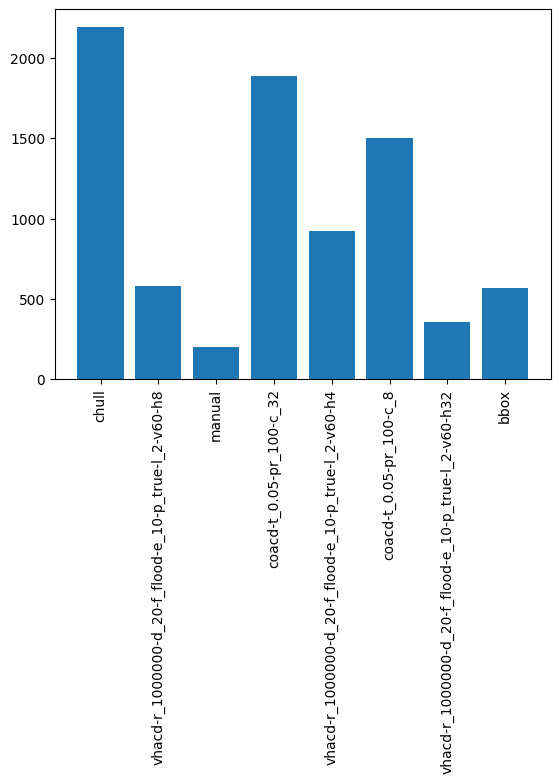

In [17]:
# Some quick analysis: plot the selection counts
import matplotlib.pyplot as plt
from collections import Counter
c = Counter(full_name_selections.values())
plt.bar(c.keys(), c.values())
plt.xticks(rotation=90)
plt.show()

{'coacd-t_0.05-pr_100-c_8', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h32', 'chull', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h4', 'coacd-t_0.05-pr_100-c_32', 'bbox', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h8'}
{'coacd-t_0.05-pr_100-c_8', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h32', 'chull', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h4', 'coacd-t_0.05-pr_100-c_32', 'bbox', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h8'}
{'coacd-t_0.05-pr_100-c_8', 'chull', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h4', 'coacd-t_0.05-pr_100-c_32', 'bbox'}
{'coacd-t_0.05-pr_100-c_8', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h32', 'chull', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h4', 'coacd-t_0.05-pr_100-c_32', 'bbox', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h8'}
{'coacd-t_0.05-pr_100-c_8', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h32', 'chull', 'vhacd-r_1000000-d_20-f_flood-e_10-p_true-l_2-v60-h4', 'coacd-

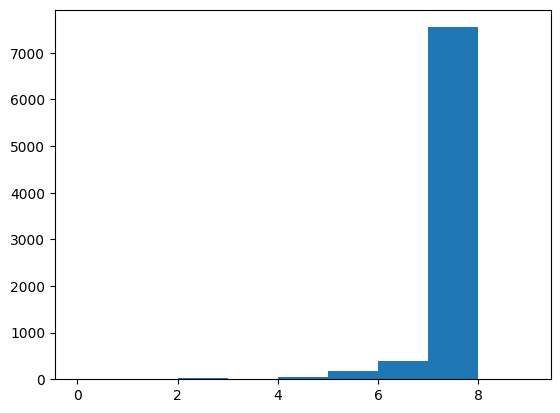

In [18]:
# How many candidates does each object have?
n_candidates = {}
for item in meshdir.glob("*"):
    if not item.is_dir():
        continue

    name = item.name
    candidates = {x.stem.rsplit("-", 1)[0] for x in item.glob("*.obj")}
    print(candidates)
    n_candidates[name] = len(candidates)

plt.hist(n_candidates.values(), bins=range(0, 10))
plt.show()

In [ ]:
# Create combined meshes
for item in meshdir.glob("*"):
    if not item.is_dir():
        continue

    name = item.name
    candidates = {x.stem.rsplit("-", 1)[0] for x in item.glob("*.obj")}